## **Pairs Trading using Spread**

**Rationale**
1. There seems to be a correlation between some of the stocks in NASDAQ and QQQ from analyzing stock prices over the past few years.
- This implies that there is a long-term relationship between the two stock prices, suggesting that they move together, making them suitable for pairs trading.

**Idea of Pairs Trading**
1. Find 2 securities, S1 and S2, that move similarly with each other (typically high positive or negative correlation)
2. Compare the spread or ratio between S1 and S2
3. When S1 and S2 start to deviate from each other, spread increases, short/sell the 'overvalued' security and long/buy the 'undervalued' security.
4. When they revert back to mean (mean-reversion), we will then sell/buy the securities accordingly.

**Limitations of This Notebook**
1. Operates at 1 hour intervals due to Yahoo Finance limitations.
- If it is a viable strategy, use API to convert to 15 min intervals.

NOTE: This Notebook is strictly for training purposes and algorithm is still very simple at this current stage.

**Gather Historical Data for all the stocks
 of interest**
 - We will use Yahoo Finance to extract potential stocks and their data.

In [1]:
import pandas as pd
import yfinance as yf
import statsmodels
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from matplotlib.pyplot import figure
from datetime import datetime
from statsmodels.tsa.stattools import coint

def get_historical_data(tickers):
    data = pd.DataFrame()
    names = list()
    for i in tickers:
        stock_data = yf.download(
            i,
            start=datetime(2024, 1, 1),
            end=datetime(2024, 10, 1),
            interval='1h',
            prepost=True
        ).iloc[:, 4]  # 'Adj Close' column (index 4)

        data = pd.concat([data, pd.DataFrame(stock_data)], axis=1)
        names.append(i)

    data.columns = names
    return data

tickers = ["QQQ", "NVDA", "AMZN", "GOOG", "AAPL", "TSLA", "META", "AVGO", "MSFT", "NFLX"]
df = get_historical_data(tickers)
df.tail(10)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,QQQ,NVDA,AMZN,GOOG,AAPL,TSLA,META,AVGO,MSFT,NFLX
Datetime,,,,,,,,,,
2024-09-30 10:30:00-04:00,486.890015,120.973801,185.530807,165.475006,231.899994,259.489990,573.349976,172.845001,427.921997,706.839905
2024-09-30 11:30:00-04:00,487.149994,120.714996,186.119995,165.990005,232.119995,260.718201,573.679993,172.089996,428.649902,707.000000
2024-09-30 12:30:00-04:00,485.720001,120.100700,185.619995,165.630005,231.645004,258.519989,570.594971,171.190002,427.459991,707.150513
2024-09-30 13:30:00-04:00,483.785004,119.470001,185.350006,165.360001,231.009995,256.869904,567.690002,170.240005,425.920013,703.820007
2024-09-30 14:30:00-04:00,485.199188,120.084999,185.550003,166.070007,231.220001,258.720001,569.400024,171.070007,427.204987,707.200012
2024-09-30 15:30:00-04:00,488.049988,121.489998,186.309998,167.179993,233.000000,261.605011,572.359985,172.460007,430.339996,709.270020
2024-09-30 16:00:00-04:00,487.150000,121.200000,185.360000,166.690000,232.860000,261.050000,572.050000,172.210000,428.160000,709.435000
2024-09-30 17:00:00-04:00,487.400000,121.060000,185.525000,166.757500,232.880000,261.070000,572.030000,172.145000,428.440000,708.685000
2024-09-30 18:00:00-04:00,487.180000,121.080000,185.640000,166.865000,232.800000,261.225500,572.330000,172.070000,428.335000,708.605000


**Test for Cointegration between the gathered stocks**

- Cointegration tests whether the 2 securities will revert around a mean over a long-period of time.
- If the difference (spread) between the 2 securities is able to form some linear combination: S2 = $\alpha$ + $\beta$ * S1 + $\epsilon$, where $\epsilon$ is stationary, then they are considered to be conintegrated.

In [2]:
def find_cointegrated_pairs(df, tickers, threshold = 0.05):
  coint_matrix = pd.DataFrame(index=tickers, columns=tickers)
  pairs = []
  for i in range(len(tickers)):
      for j in range(len(tickers)):
          if i != j:
              stock1_data = df[tickers[i]].dropna()
              stock2_data = df[tickers[j]].dropna()

              # Align the data based on their indices
              aligned_data = pd.concat([stock1_data, stock2_data], axis=1, join='inner')
              aligned_data.columns = [tickers[i], tickers[j]]

              # Check if there's enough data after aligning
              if len(aligned_data) > 1:
                  score, p_value, _ = coint(aligned_data[tickers[i]], aligned_data[tickers[j]])
                  coint_matrix.iloc[i, j] = p_value  # Store the p-value in the matrix
                  if p_value < threshold:
                      pairs.append((tickers[i], tickers[j]))
              else:
                  coint_matrix.iloc[i, j] = np.nan  # Not enough data for cointegration test
          else:
              coint_matrix.iloc[i, j] = np.nan  # Diagonal elements are NaN

  return coint_matrix, pairs

Pairs:[('QQQ', 'AVGO'), ('META', 'NFLX'), ('AVGO', 'QQQ'), ('AVGO', 'NFLX'), ('NFLX', 'AVGO')]


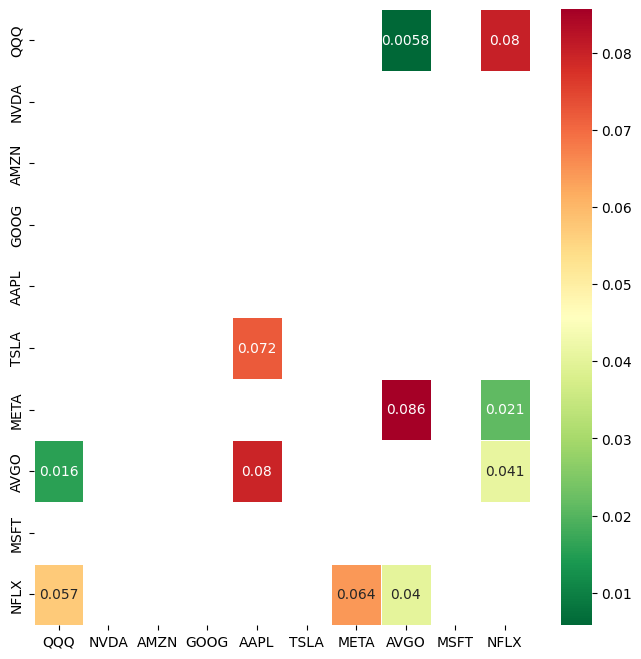

In [3]:
coint_matrix, pairs = find_cointegrated_pairs(df, tickers)

print(f"Pairs:{pairs}")

coint_long = coint_matrix.reset_index().melt(id_vars='index', var_name='Stock2', value_name='P-Value')
coint_long.rename(columns={'index': 'Stock1'}, inplace=True)

# Remove any rows with NaN P-values (like diagonal elements or where there's insufficient data)
coint_long.dropna(subset=['P-Value'], inplace=True)

# Create a heatmap using Seaborn
plt.figure(figsize=(8, 8))
heatmap_data = coint_matrix.astype(float)  # Ensure values are float for proper heatmap scaling

# Generate the heatmap
sns.heatmap(heatmap_data, annot=True, cmap='RdYlGn_r', cbar=True, linewidths=0.5, mask = (heatmap_data >= 0.1))


# Show the plot
plt.show()

**Test for Correlation between all the gathered stocks**

<Axes: >

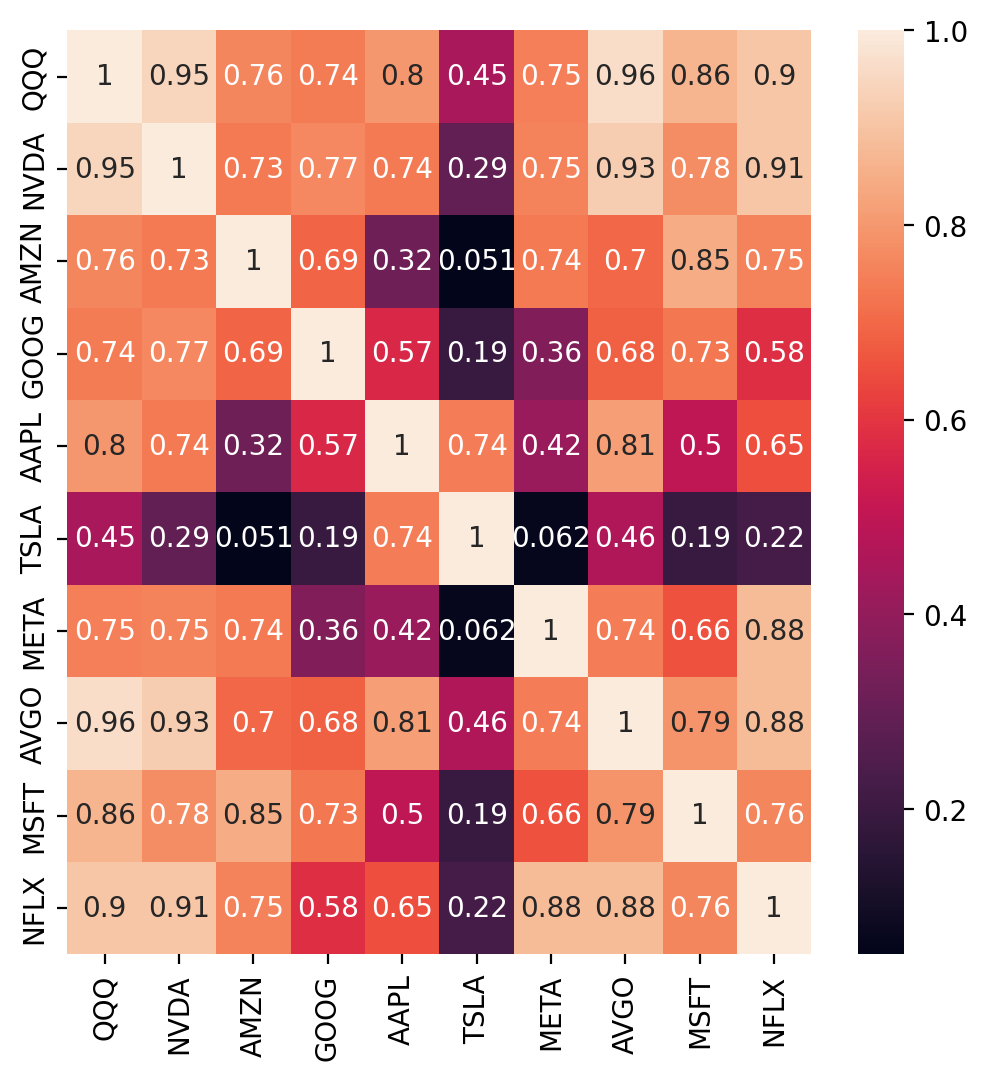

In [4]:
corr_matrix = df.corr()

figure(figsize=(6, 6), dpi=200)
sns.heatmap(corr_matrix, annot = True)

**Calculate Spread between the 2 Stocks**
- For this notebook, we will calculate the spread between AVGO (S1) and QQQ (S2)
- As there exists a linear combination such that S2 = $\alpha$ + $\beta$ * S1 + $\epsilon$, we can shift the variables around to obtain the following equation: Spread = S2 - $\beta$ * S1

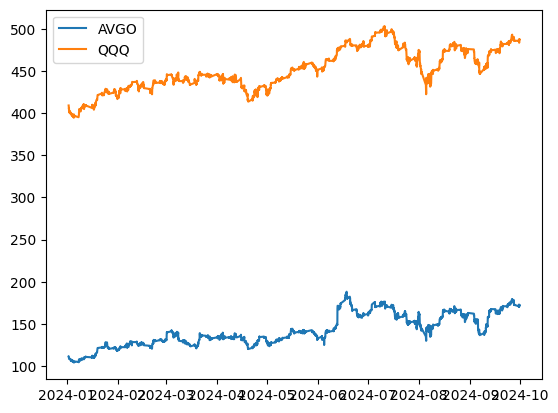

In [5]:
s1_name = 'AVGO'
s2_name = 'QQQ'
S1 = df[s1_name]
S2 = df[s2_name]

plt.plot(S1, label = s1_name)
plt.plot(S2, label = s2_name)
plt.legend()

Text(0.5, 1.0, 'Spread between AVGO and QQQ')

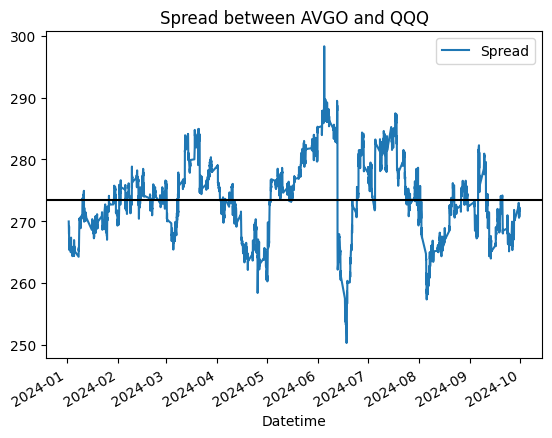

In [6]:
aligned_data = pd.concat([S1, S2], axis=1).dropna()
S1 = aligned_data[s1_name]
S2 = aligned_data[s2_name]

S1_with_const = sm.add_constant(S1)
results = sm.OLS(S2, S1_with_const).fit()
b = results.params[s1_name]  # Align it with S1 as it is the predictor

spread = S2 - b * S1
spread.plot()
plt.axhline(spread.mean(), color='black')
plt.legend(['Spread'])

plt.title(f'Spread between {s1_name} and {s2_name}')

Calculate z-scores to normalize signals

In [7]:
def zscore(series):
    return (series - series.mean()) / np.std(series)

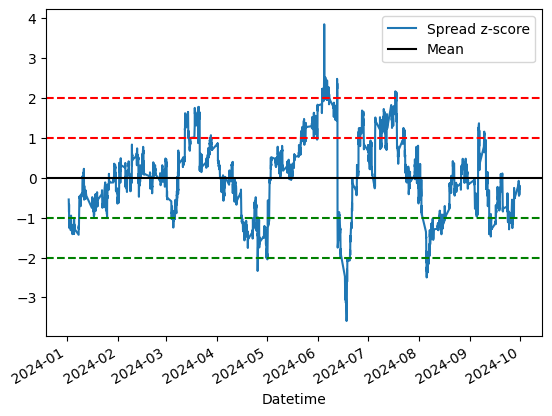

In [8]:
zscore(spread).plot()
plt.axhline(zscore(spread).mean(), color='black')
plt.axhline(1.0, color='red', linestyle='--') # 68% of the data will lie between these bounds
plt.axhline(2.0, color='red', linestyle='--') # 95% of the data will lie between these bounds
plt.axhline(-1.0, color='green', linestyle='--')
plt.axhline(-2.0, color='green', linestyle='--')
plt.legend(['Spread z-score', 'Mean'])

NOTE: As we took all the data points to compute the overall mean, there will be some biases involved in our calculation. 

Take one data point, say 2024-03-01. Its mean is computed using data points extending all the way to 2024-10-01, which had not yet occurred at that time, resulting in look-ahead bias. In later steps, we will use a rolling window to compute the moving average and reduce these biases.

**Using Moving Average to eliminate look-ahead bias**
- As the current mean takes into account of data from start to end, it falls prey to the look-ahead bias.
- As such, use a rolling window (moving average) to eliminate the bias.

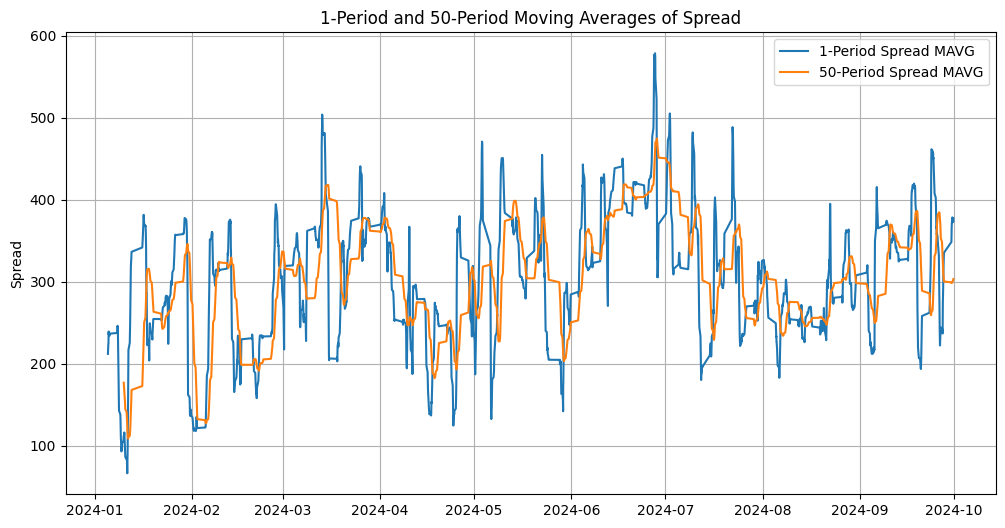

In [9]:
# Ensure S1 and S2 are aligned and drop NaN values
align_S1, align_S2 = S1.align(S2, join='inner')

def calculate_beta(x, y):
    X_with_const = sm.add_constant(x)  # Add constant for intercept
    model = sm.OLS(y, X_with_const).fit()  # Fit the OLS model
    return model.params.iloc[1]  # Return the beta (slope) coefficient

def calculate_rolling_beta(S1, S2, window):
    rolling_betas = []
    for i in range(window, len(S1) + 1):
        X_window = S1.iloc[i-window:i]
        y_window = S2.iloc[i-window:i]
        beta = calculate_beta(X_window, y_window)
        rolling_betas.append(beta)

    return pd.Series(rolling_betas, index=S1.index[window-1:])

# Calculate rolling beta with a window size of 50
rolling_beta = calculate_rolling_beta(align_S1, align_S2, window=50)

# Calculate the spread (difference between S2 and beta-adjusted S1)
spread = align_S2[rolling_beta.index] - rolling_beta * align_S1[rolling_beta.index]
spread.name = 'Spread'

# Calculate moving averages
spread_mavg1 = spread.rolling(window=1).mean()
spread_mavg1.name = 'Spread 1-Period MAVG'

spread_mavg50 = spread.rolling(window=50).mean()
spread_mavg50.name = 'Spread 50-Period MAVG'

# Plot the spread moving averages
plt.figure(figsize=(12, 6))
plt.plot(spread_mavg1.index, spread_mavg1.values, label='1-Period Spread MAVG')
plt.plot(spread_mavg50.index, spread_mavg50.values, label='50-Period Spread MAVG')

plt.legend()
plt.ylabel('Spread')
plt.title('1-Period and 50-Period Moving Averages of Spread')
plt.grid()
plt.show()


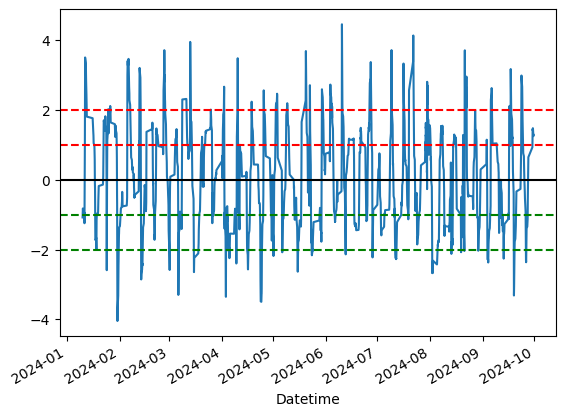

In [10]:
std_50 = spread.rolling(window=50).std()
std_50.name = 'std 50p'

zscore_spread_50_1 = (spread_mavg1 - spread_mavg50)/std_50
zscore_spread_50_1.name = 'z-score'
zscore_spread_50_1.plot()
plt.axhline(0, color='black')
plt.axhline(1.0, color='red', linestyle='--')
plt.axhline(2.0, color='red', linestyle='--')
plt.axhline(-1.0, color='green', linestyle='--')
plt.axhline(-2.0, color='green', linestyle='--')

**Implement and Test Strategy**

For the implementation of the strategy, I have decided to opt for a simple strategy.

The Strategy is as follows:

1. LONG S2 and SHORT S1 if z-score falls below -1
2. SHORT S2 and LONG S1 if z-score rises above 1.
3. The exit strategy will be when z-score reverts back to 0 for both cases.
4. Calculate Net Revenue, Total Entries, Number of Wins, Number of Losses

In [11]:
def calculate_profit(sell_price, buy_price, wins, losses, type):
  if type == 'long':
    revenue = sell_price - buy_price
  elif type == 'short':
    revenue = buy_price - sell_price
  else:
    print("ERROR: Type Given is Incorrect")
  
  wins, losses = (wins + 1, losses) if revenue >= 0 else (wins, losses + 1)

  return revenue, wins, losses

def plot_strategy(profit):
    fig, ax1 = plt.subplots(1, 1, figsize=(24, 5))
    ax1.plot(profit.index, profit, color='b')
    ax1.set_ylabel('Cumulative Profit ($)')
    ax1.set_xlabel('Date')

    return ax1

def purchase_shares(entry_date, entry_price):
    return [entry_date, entry_price]

def calculate_pairs_trade_strategy(stock1, stock2, zscores, lower_threshold = -1, upper_threshold = 1, exit_threshold = 0):
  long_holdings_s1, long_holdings_s2 = [], []
  short_holdings_s1, short_holdings_s2 = [], []
  revenue_df1, revenue_df2 =  pd.Series(index=stock1.index), pd.Series(index=stock2.index)
  revenue_df1.fillna(0, inplace=True)
  revenue_df2.fillna(0, inplace=True)
  total_count, s1_net_revenue, s2_net_revenue, wins, losses = 0, 0, 0, 0, 0
  
  for i in range(1, len(zscores)):

    #ENTRY
    if zscores.iloc[i - 1] >= lower_threshold and zscores.iloc[i] < lower_threshold:
      long_holdings_s2.append(purchase_shares(zscores.index[i], stock2[zscores.index[i]]))
      short_holdings_s1.append(purchase_shares(zscores.index[i], stock1[zscores.index[i]]))
      total_count += 2

    if zscores.iloc[i-1] <= upper_threshold and zscores.iloc[i] > upper_threshold:
      short_holdings_s2.append(purchase_shares(zscores.index[i], stock2[zscores.index[i]]))
      long_holdings_s1.append(purchase_shares(zscores.index[i], stock1[zscores.index[i]]))
      total_count += 2

    #EXIT
    if zscores.iloc[i-1] < exit_threshold and zscores.iloc[i] >= exit_threshold:
      for holding in long_holdings_s2:
        profit_s2, wins, losses = calculate_profit(stock2[zscores.index[i]], holding[1], wins, losses, type='long')
        revenue_df2.iloc[i] += profit_s2
      long_holdings_s2 = []
      for holding in short_holdings_s1:
        profit_s1, wins, losses = calculate_profit(stock1[zscores.index[i]], holding[1], wins, losses, type = 'short')
        revenue_df1.iloc[i] += profit_s1
      short_holdings_s1 = []

    if zscores.iloc[i-1] > exit_threshold and zscores.iloc[i] <= exit_threshold:
      for holding in short_holdings_s2:
        profit_s2, wins, losses = calculate_profit(stock2[zscores.index[i]], holding[1], wins, losses, type = 'short')
        revenue_df2.iloc[i] += profit_s2
      short_holdings_s2 = []
      for holding in long_holdings_s1:
        profit_s1, wins, losses = calculate_profit(stock1[zscores.index[i]], holding[1], wins, losses, type='long')
        revenue_df1.iloc[i] += profit_s1
      long_holdings_s1 = []

  s1_net_revenue = revenue_df1.cumsum()
  s2_net_revenue = revenue_df2.cumsum()

  return s1_net_revenue, s2_net_revenue, [total_count, wins, losses]

<Figure size 2600x1800 with 0 Axes>

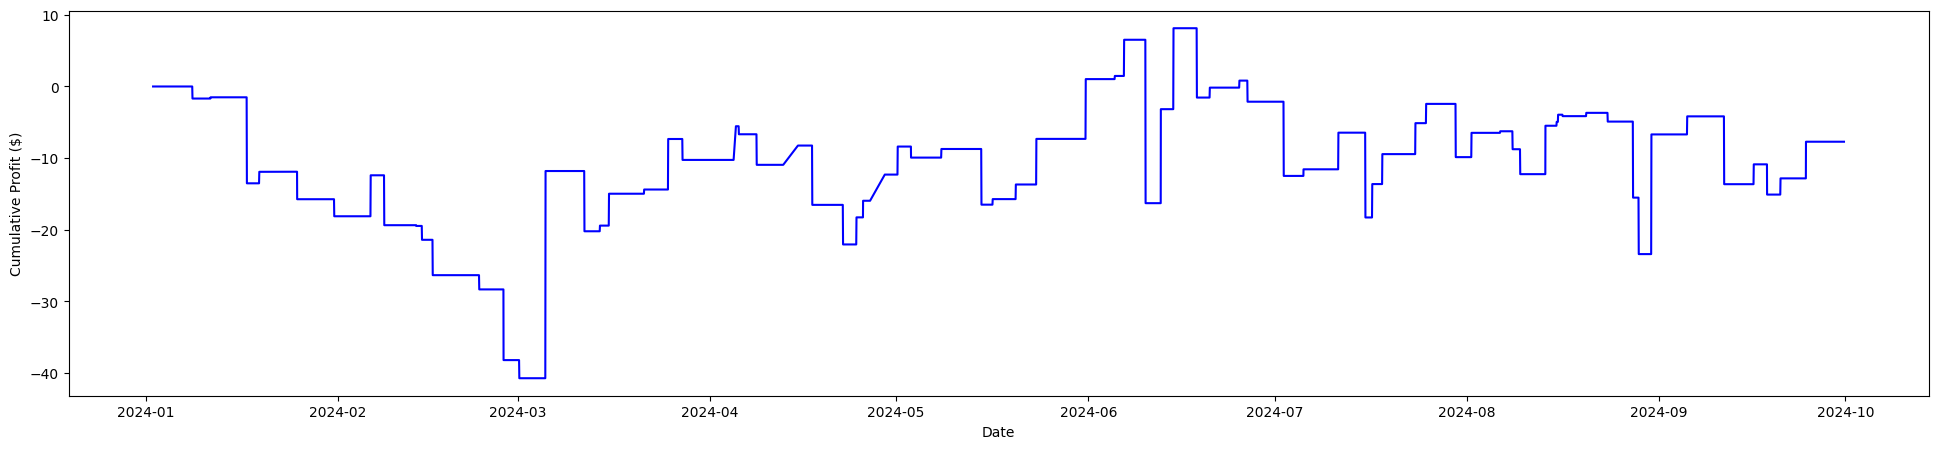

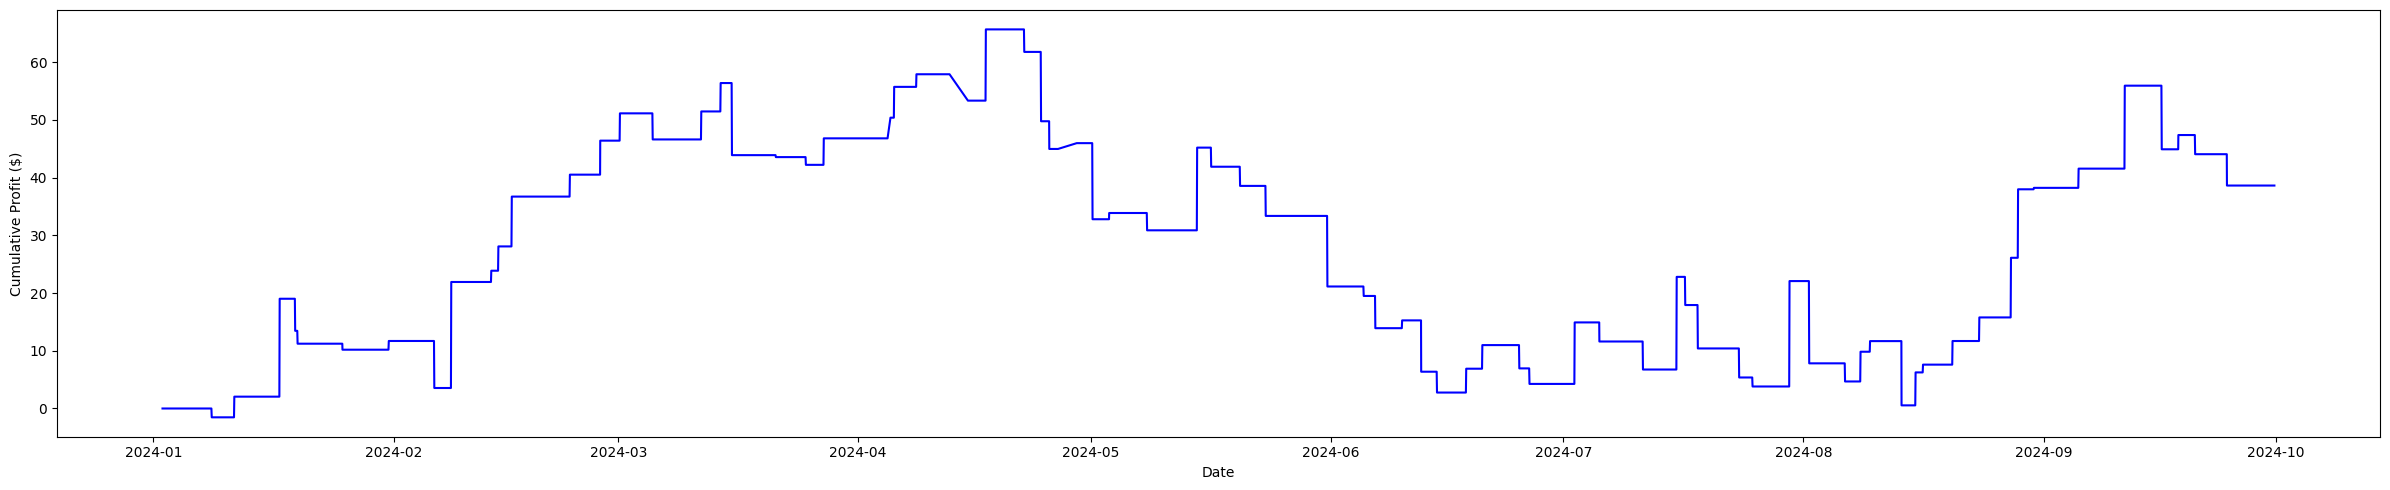

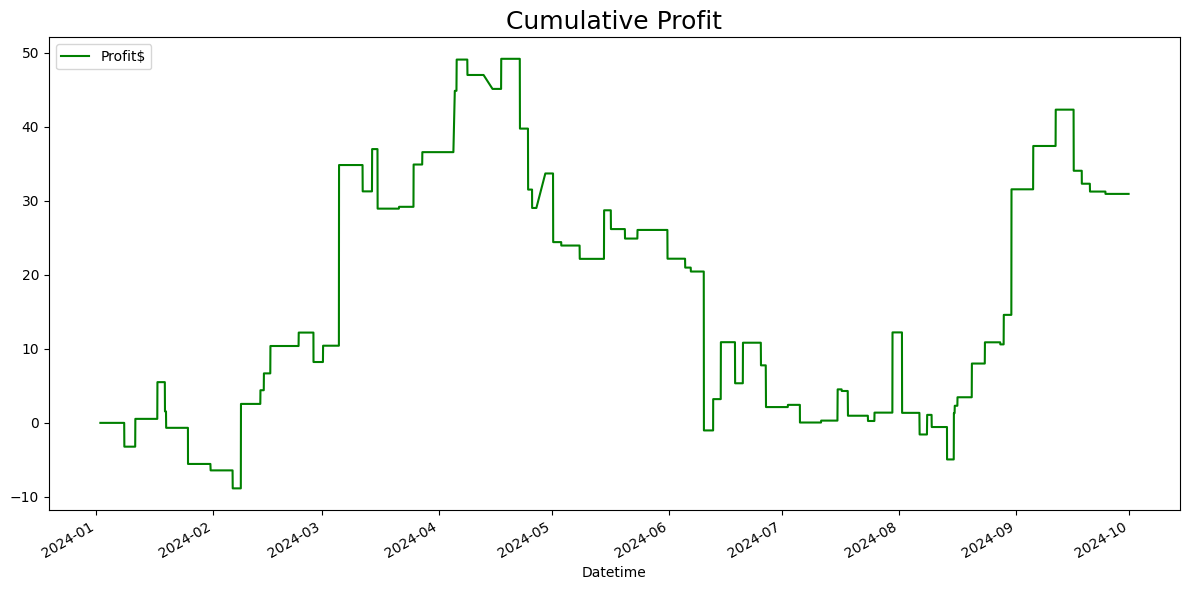

TOTAL ENTRIES: 204
TOTAL WINS: 109
TOTAL LOSSES: 93


In [12]:
lower_threshold = -1
upper_threshold = 1
exit_threshold = 0

zscore_spread_50_1.columns = ['Datetime', 'z-score']

s1_net_revenue, s2_net_revenue, results = calculate_pairs_trade_strategy(S1, S2, zscore_spread_50_1, lower_threshold, upper_threshold, exit_threshold)

plt.figure(figsize=(26, 18))
ax1 = plot_strategy(s1_net_revenue)
ax2 = plot_strategy(s2_net_revenue)

plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
cumulative_profit_combined = s1_net_revenue + s2_net_revenue
ax2_combined = cumulative_profit_combined.plot(
    label='Profit$', color='green')
plt.legend(loc='upper left', fontsize=10)
plt.title('Cumulative Profit', fontsize=18)
plt.tight_layout()
plt.show()

print(f"TOTAL ENTRIES: {results[0]}")
print(f"TOTAL WINS: {results[1]}")
print(f"TOTAL LOSSES: {results[2]}")

**CONCLUSION**
- As the current strategy is considered to be very basic, it is expected that the strategy will not be very profitable. However, this does give us an insight as to how basic pairs trading is done.

**FUTURE WORKS**
- Develop Pairs Trading Algorithm using Price Ratios and/or Log Price Ratios
- Introduce other statistical methods such as Hurst Exponent, Half-Life of Mean Revision, Kalman Filters, etc.